In [1]:
# Packages
include("DendriticBranches.jl")
using .DendriticBranches: is_subset, is_contiguous_subset, find_first_target_symbols
using StatsBase, Distributions, Plots, ROCAnalysis, Serialization, Measures

In [2]:
const trial = Vector{Tuple{Vector{Symbol}, Vector{Float64}, Bool}} 
const contingency = Vector{Tuple{Float64,Int64, Int64,Int64, Int64}}

Vector{Tuple{Float64, Vararg{Int64, 4}}} (alias for Array{Tuple{Float64, Vararg{Int64, 4}}, 1})

In [3]:
# Distributions

function gaussian(; args::NamedTuple)
    # negative values are truncated
    value = rand(Normal(args.mean, args.sd))
    return value > 0 ? value : gaussian(args=(mean=args.mean, sd=args.sd))
end
 
function uniform(; args::NamedTuple )
    return rand(Uniform(args.bound_start,args.bound_end))
end

uniform (generic function with 1 method)

In [4]:
# A function that saves performances in a .jls file 
function save_performances(performance, experiment_name, file_path)
    variables_dict = Dict{String, Any}()

    # LOAD EXISTING DATA 
    if filesize(file_path) != 0
        existing_variables = open(file_path, "r") do file
            deserialize(file)
        end
        merge!(variables_dict, existing_variables) 
    end 
    
    # ADD NEW PERFORMANCE 
    variables_dict[experiment_name] = performance
    open(file_path, "w") do file
        serialize(file, variables_dict)
    end

end 

function load_performances(;experiment_name=nothing, file_path)
    variables_dict = open(file_path, "r") do file
        deserialize(file)
    end
    return isnothing(experiment_name) ? variables_dict : variables_dict[experiment_name]
end  

load_performances (generic function with 1 method)

In [5]:
function check_extra_condition(seq::Vector{Symbol}, subseq::Vector{Symbol})
    indices = find_first_target_symbols(seq, subseq)
    return isnothing(indices) ? false : all(abs(indices[i] - indices[i-1]) >= 2 for i in 2:length(indices))
end

function check_extra_condition(seq::Vector{Symbol}, branching::Vector{Any})
    indices = find_first_target_symbols(seq, branching)
    return any(x-> isnothing(x) ? false : all(abs(x[i] - x[i-1]) >= 2 for i in 2:length(x)), indices)
end

check_extra_condition (generic function with 2 methods)

In [6]:
function gen_seuqence(alphabet::Vector{Symbol} , length::Int64)
    return StatsBase.sample(alphabet,length)
end


function generate_timings(sequence_length::Int64,timing_distribution::Function, distribution_args::NamedTuple)
    timings = Float64[]
    for index in 1:sequence_length
        if index == 1
            push!(timings, 0.0 + (timing_distribution(args=distribution_args)))
        else 
            push!(timings, timings[index - 1] + (timing_distribution(args=distribution_args)))

        end
    end
    return timings
end


function generate_trails(alphabet::Vector{Symbol}, 
                         sequence_length::Int64, 
                         target::Vector{T} where T<:Union{Symbol, Any},
                         timing_distribution::Function,
                         distribution_args::NamedTuple
                         ; trail_count::Int64 = 50 , balanced = true, extra_condition= false)
    trials = Tuple{Vector{Symbol},Vector{Float64}, Bool}[]
    
    if !balanced
        truth_count = 0
        while length(trials) != trail_count
            sequence = gen_seuqence(alphabet,sequence_length)
            timings = generate_timings(sequence_length,timing_distribution,distribution_args)
            if is_subset(target, sequence) 
                truth = is_contiguous_subset(target,sequence)
                truth_count += truth ? 1 : 0
                push!(trials,(sequence,timings, truth))     
            end
        end
    else
        while length(trials) != floor(trail_count/2)
            sequence = gen_seuqence(alphabet,sequence_length)
            timings = generate_timings(sequence_length,timing_distribution,distribution_args)
            if is_subset(target, sequence) && is_contiguous_subset(target,sequence) 
                push!(trials,(sequence,timings, is_contiguous_subset(target,sequence)))
            end
        end

        # in false trials the target needs to be in the sequence however with at least one distractors in between
        if extra_condition 
            while length(trials) != trail_count
                sequence = gen_seuqence(alphabet,sequence_length)
                timings = generate_timings(sequence_length,timing_distribution,distribution_args)
                if is_subset(target, sequence) && !is_contiguous_subset(target,sequence) && check_extra_condition(sequence, target) 
                    push!(trials,(sequence,timings, is_contiguous_subset(target,sequence)))
                end
            end

        else 
            while length(trials) != trail_count
                sequence = gen_seuqence(alphabet,sequence_length)
                timings = generate_timings(sequence_length,timing_distribution,distribution_args)
                if is_subset(target, sequence) && !is_contiguous_subset(target,sequence) 
                    push!(trials,(sequence,timings, is_contiguous_subset(target,sequence)))
                end
            end
        end 
    end

    return trials
end


function find_all_target_indices(seq::Vector{Symbol} , subseq::Vector{Symbol})
    indices = Int64[]
    len_subseq = length(subseq)
    len_seq = length(seq)
    for i in 1:(len_seq - len_subseq + 1)
        if seq[i:i+len_subseq-1] == subseq
            push!(indices,i)
        end
    end
    return indices
end

find_all_target_indices (generic function with 1 method)

In [7]:
function contingency_table(trials::trial, predictions::Vector{Bool}, tau::Float64)
    fp = 0
    fn = 0 
    tp = 0
    tn = 0
    for index in 1:length(trials)
        if trials[index][3] == true && predictions[index] == false
            fn += 1
        elseif trials[index][3] == false && predictions[index] == true
            fp += 1
        elseif trials[index][3] == false && predictions[index] == false
            tn += 1
        elseif trials[index][3] == true && predictions[index] == true
            tp += 1
        
        end
    end
    return (tau,fp,fn,tp,tn)
end

contingency_table (generic function with 1 method)

In [8]:
function naive_dendritic_classifier(trials::trial , target::Vector{Symbol}, tau::Float64)
    detected = Bool[]
    for trial in trials
        target_location = find_first_target_symbols(trial[1],target)
        if target_location != nothing
            detect = true
            for i in 1:(length(target_location) - 1)
                detect &= ( tau >= (trial[2][target_location[i+1]] - trial[2][target_location[i]]))
            end
            push!(detected,detect)

        else 
            push!(detected,false)
        end
    end
    
    return detected, contingency_table(trials, detected ,tau)
end

naive_dendritic_classifier (generic function with 1 method)

In [9]:
function naive_dendritic_classifier(trials::trial , target::Vector{Any}, tau::Float64)
    detected = Bool[]
    for trial in trials
        target_locations = find_first_target_symbols(trial[1], target)
        if any(x -> test_target_location(x, trial, tau), target_locations)
            push!(detected, true)
        else 
            push!(detected, false )
        end 
    end
    
    return detected, contingency_table(trials, detected ,tau)
end

naive_dendritic_classifier (generic function with 2 methods)

In [10]:
function test_target_location(target_location, trial, tau)
    if target_location != nothing
        detect = true
        for i in 1:(length(target_location) - 1)
            detect &= ( tau >= (trial[2][target_location[i+1]] - trial[2][target_location[i]]))
        end
        return detect 
    else 
        return false 
    end
end 

test_target_location (generic function with 1 method)

In [11]:
# performance tuple structure : (tau,fp,fn,tp,tn)

function accuracy(performance::contingency, trialcount::Int64)
    accuracy = Float64[]
    tau = Float64[]
    for table in performance
        acc = ((table[4] + table[5]) / trialcount ) * 100.0
        push!(accuracy, acc )
        push!(tau, table[1])
    end
    return tau, accuracy
end

function f_score(performance::contingency)
    score = Float64[]
    tau = Float64[]
    for table in performance
        fscore = ((table[4]) / (table[4] + ((table[2] + table[3]) * 0.5)) ) * 100.0
        push!(score, fscore )
        push!(tau, table[1])
    end
    return tau, score
end

function sensitivity(performance::contingency)
    sensitivities = Float64[]
    tau = Float64[]
    for table in performance
        sens = ((table[4]) / (table[4] + table[3]) ) * 100.0
        push!(sensitivities, sens )
        push!(tau, table[1])
    end
    return tau, sensitivities
end

function specificity(performance::contingency)
    specificities = Float64[]
    tau = Float64[]
    for table in performance
        spec = ((table[5]) / (table[5] + table[2]) ) * 100.0
        push!(specificities, spec )
        push!(tau, table[1])
    end
    return tau, specificities
end

function TPR_FPR(performance::contingency)
    TP_rate = Float64[]
    FP_rate = Float64[]
    for table in performance
        push!(TP_rate, (table[4] / (table[4] + table[3])) * 100 )
        push!(FP_rate, (table[2] / (table[2] + table[5])) * 100)
    end
    return FP_rate,TP_rate
end

function balanced_accuracy(performance::contingency)
    balanced_accuracies = Float64[]
    tau = Float64[]
    for table in performance 
        sensitivity = table[4] / (table[4] + table[3]) * 100.0
        specificity = table[5] / (table[5] + table[2]) * 100.0
        balanced_accuracy = (sensitivity + specificity) / 2
        push!(balanced_accuracies, balanced_accuracy)
        push!(tau, table[1])
    end 
    return tau, balanced_accuracies
end

function matthews_correlation(performance::contingency)
    correlations = Float64[]
    tau = Float64[]
    for table in performance 
        fp, fn, tp, tn = table[2], table[3], table[4], table[5]
        numerator = tp * tn - fp * fn
        denominator = sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
        mcc = (numerator / denominator) * 100
        push!(correlations, mcc)
        push!(tau, table[1])
    end 
    return tau, correlations
end

matthews_correlation (generic function with 1 method)

In [12]:
function experiment(dist::Function,
                    distribution_args::NamedTuple;
                    setup::NamedTuple
                    )
    
    trials = generate_trails(setup.alphabet,
                             setup.sequence_length,
                             setup.target,
                             dist,
                             distribution_args, 
                             trail_count = setup.trial_per_experiment,
                             balanced = setup.balanced, 
                             extra_condition = setup.extra_condition)
    predictions = Tuple{Float64,Vector{Bool}}[]
    performance = Tuple{Float64,Int64, Int64,Int64, Int64}[]
    for tau in setup.min_tau:setup.step:setup.max_tau
        predict , table = naive_dendritic_classifier(trials,setup.target,tau)
        push!(performance, table)
        push!(predictions, (tau , predict))
    end
    return predictions,performance
end

experiment (generic function with 1 method)

In [13]:
function uniform_experiment(dist::Function,
                    distribution_args::NamedTuple;
                    setup::NamedTuple
                    )
    
    trials = generate_trails(setup.alphabet,
                             setup.sequence_length,
                             setup.target,
                             dist,
                             distribution_args, 
                             trail_count = setup.trial_per_experiment,
                             balanced = setup.balanced, 
                             extra_condition = setup.extra_condition)
    predictions = Tuple{Float64,Vector{Bool}}[]
    performance = Tuple{Float64,Int64, Int64,Int64, Int64}[]
    predict , table = naive_dendritic_classifier(trials,setup.target,setup.min_tau)
    push!(performance, table)
    push!(predictions, (setup.min_tau , predict))
    return predictions,performance
end

uniform_experiment (generic function with 1 method)

In [14]:
function draw(performances,distribution;setup::NamedTuple, legend=false)
    performance = performances[2]
    distargs = performances[1]
    tau , score = f_score(performance)
    _ , sensitivities = sensitivity(performance)
    _ , specificities = specificity(performance)
    _ , acc = accuracy(performance,setup.trial_per_experiment)
    _ , correlations = matthews_correlation(performance)
    _ , balanced_acc = balanced_accuracy(performance)
    #plot_title = "performance measures on timings from\n $dist_name distribution with $distribution_arguments"
    if setup.balanced == true 
        plot_title = "Performance measures for $(setup.trial_per_experiment) sequence trials of the length $(setup.sequence_length) and target: $(setup.target_identifier). \n Trials were balanced: $(setup.balanced) with extra condition: $(setup.extra_condition)  \n Timing jitters from $distribution with: $distargs \n"
    else 
        plot_title = "Performance measures for $(setup.trial_per_experiment) sequence trials of the length $(setup.sequence_length) and target: $(setup.target_identifier). \n Trials were balanced: $(setup.balanced)\n Timing jitters from $distribution with: $distargs "
    end 
    plot(tau , score; title= plot_title, label = "f1 score curve",lw=3,titlefontsize=10)
    plot!(tau , acc; title= plot_title, label = "accuracy curve",lw=3,titlefontsize=10)
    plot!(tau , sensitivities; title= plot_title, label = "sensitivities curve",lw=2, linestyle=:dash,titlefontsize=10)
    plot!(tau , specificities; title= plot_title, label = "specificity curve",lw=2,linestyle=:dash,titlefontsize=10)
    plot!(tau , correlations; title= plot_title, label = "matthews correlation curve",lw=2,linestyle=:dash,titlefontsize=10)

    # nur wenn not balanced? 
    if setup.balanced == false 
        plot!(tau , balanced_acc; title= plot_title, label = "balanced accuracy curve",lw=2,linestyle=:dash,titlefontsize=10)
    end 
    plot!(ylims = (0,100))
    plot!(xlabelfontsize=10)
    plot!(ylabelfontsize=10)
    ylabel!(" \n Performance (%)")
    xlabel!("Plateau length (ms) \n")
    plot!(legend=:outerbottom ,legendfontsize=10)

end

draw (generic function with 1 method)

In [15]:
function draw_roc(performances,distribution;setup::NamedTuple)
    performance = performances[2]
    distargs = performances[1]
    tau, _ = f_score(performance)
    FPR, TPR = TPR_FPR(performance)
    r = roc(TPR, FPR)
    AUC_score = AUC(r)
    
    if setup.balanced == true
        plot_title = "ROC measures for $(setup.trial_per_experiment) sequence trials of the length $(setup.sequence_length) and target: $(setup.target_identifier). \n Trials were balanced: $(setup.balanced) with extra_condition: $(setup.extra_condition) \n from $distribution with: $distargs \n AUC: $AUC_score \n"
    else 
        plot_title = "ROC measures for $(setup.trial_per_experiment) sequence trials of the length $(setup.sequence_length) and target: $(setup.target_identifier). \n Trials were balanced: $(setup.balanced) from $distribution with: $distargs \n AUC: $AUC_score \n"
    end 
    plot(FPR , TPR; title= plot_title, label = "ROC curve for plateau length",lw=3,titlefontsize=7)
    plot!(ylims = (0,100))
    plot!(xlims = (0,100))
    plot!(xlabelfontsize=7)
    plot!(ylabelfontsize=7)
    plot!(legend=:outerbottom ,legendfontsize=7)
    ylabel!("True Positive Rate %")
    xlabel!("False Positive Rate % \n")
end

draw_roc (generic function with 1 method)

In [16]:
# DENDRITIC STRUCTURES

# TYPE E 
target_E1 = [:A, :B, :C]

# TYPE D 
target_D1 = [ [:||, :A, :B], :C ]
target_D2 = [ [:&, :A, :B], :C ]

# TYPE F 
target_F1 = [ [:&, [ [:||, :A, :B], :C], :D], :E] 
target_F2 = [ [:&, [ [:&, :A, :B], :C], :D], :E] 

# TYPE G
target_G1 = [ [:&, [[:||, :A, :B], :E], [[:&, :D, :C], :F] ], :G ] 
target_G2 = [ [:&, [[:&, :A, :B], :E], [[:&, :D, :C], :F] ], :G ] 

2-element Vector{Any}:
 Any[:&, Any[[:&, :A, :B], :E], Any[[:&, :D, :C], :F]]
 :G

In [17]:
function plot_progress(iteration, total)
    progress = round(iteration / total * 100)
    bar_length = 50
    num_bars = round(Int, progress / (100 / bar_length))
    remaining_bars = bar_length - num_bars
    bar = "[" * repeat("=" , num_bars) * repeat(" ", remaining_bars) * "]"
    print("\rProgress: $bar ($progress%)")
end

plot_progress (generic function with 1 method)

In [18]:
# # NEW EXPERIMENT 
# experiment_filename = "target_E1_balanced_gaussian_sd_25_extra_condition"
# file_path = "D:/Bachelor_Thesis_Code/Performances/E1/performances_E1.jls"

# # SETUP 
# experiment_setup = (alphabet = [:A, :B, :C, :D],
#         target = target_E1,
#         target_identifier = "E1",
#         sequence_length=10,
#         trial_per_experiment = 600,
#         min_tau = 20.0,
#         max_tau= 600.0,
#         step=1.0,
#         balanced = true, 
#         extra_condition = true
#         )
# distname = gaussian
# performances = Tuple[]

# # EXPERIMENT 
# for i in 1:1:400
#         plot_progress(i, 400)
#         distargs = (mean = i, sd = 25)
#         _ , performance = experiment(distname,distargs;setup=experiment_setup)
#         push!(performances,(distargs, performance))
# end
    
# # SAVE PERFORMANCES 
# save_performances(performances, experiment_filename, file_path)

In [19]:
# LOAD EXPERIMENT DATA 
experiment_filename = "target_E1_balanced_gaussian_sd_25_extra_condition"
file_path = "D:/Bachelor_Thesis_Code/Performances/target_E1/performances_E1.jls"

# SETUP 
experiment_setup = (alphabet = [:A, :B, :C, :D],
        target = target_E1,
        target_identifier = "E1",
        sequence_length=10,
        trial_per_experiment = 600,
        min_tau = 20.0,
        max_tau=600.0,
        step=1.0,
        balanced = true, 
        extra_condition = true
        )
distname = gaussian

performances = load_performances(experiment_name=experiment_filename, file_path=file_path)

400-element Vector{Tuple}:
 ((mean = 1, sd = 25), [(20.0, 3, 262, 38, 297), (21.0, 3, 259, 41, 297), (22.0, 3, 253, 47, 297), (23.0, 5, 250, 50, 295), (24.0, 5, 246, 54, 295), (25.0, 6, 240, 60, 294), (26.0, 7, 237, 63, 293), (27.0, 7, 231, 69, 293), (28.0, 8, 227, 73, 292), (29.0, 8, 223, 77, 292)  …  (591.0, 300, 0, 300, 0), (592.0, 300, 0, 300, 0), (593.0, 300, 0, 300, 0), (594.0, 300, 0, 300, 0), (595.0, 300, 0, 300, 0), (596.0, 300, 0, 300, 0), (597.0, 300, 0, 300, 0), (598.0, 300, 0, 300, 0), (599.0, 300, 0, 300, 0), (600.0, 300, 0, 300, 0)])
 ((mean = 2, sd = 25), [(20.0, 3, 262, 38, 297), (21.0, 3, 261, 39, 297), (22.0, 3, 255, 45, 297), (23.0, 3, 253, 47, 297), (24.0, 3, 250, 50, 297), (25.0, 4, 244, 56, 296), (26.0, 4, 235, 65, 296), (27.0, 4, 231, 69, 296), (28.0, 5, 229, 71, 295), (29.0, 5, 223, 77, 295)  …  (591.0, 300, 0, 300, 0), (592.0, 300, 0, 300, 0), (593.0, 300, 0, 300, 0), (594.0, 300, 0, 300, 0), (595.0, 300, 0, 300, 0), (596.0, 300, 0, 300, 0), (597.0, 300, 0, 30

In [21]:
# DISPLAY ALL RESULTS AT FILE PATH 
file_path = "D:/Bachelor_Thesis_Code/Performances/target_E1/performances_E1.jls"
#file_path ="D:/Bachelor_Thesis_Code/Performances/uniform_experiment/performances_uniform.jls"
for k in keys(load_performances(file_path=file_path))
    println(k)
end 

target_E1_balanced_gaussian_sd_10
target_E1_UNBALANCED_gaussian_sd_10
target_E1_UNBALANCED_gaussian_sd_50
target_E1_balanced_gaussian_sd_10_extra_condition
target_E1_balanced_gaussian_sd_50_extra_condition
target_E1_balanced_gaussian_sd_25_extra_condition
target_E1_balanced_gaussian_sd_25
target_E1_balanced_gaussian_sd_50
target_E1_UNBALANCED_gaussian_sd_25


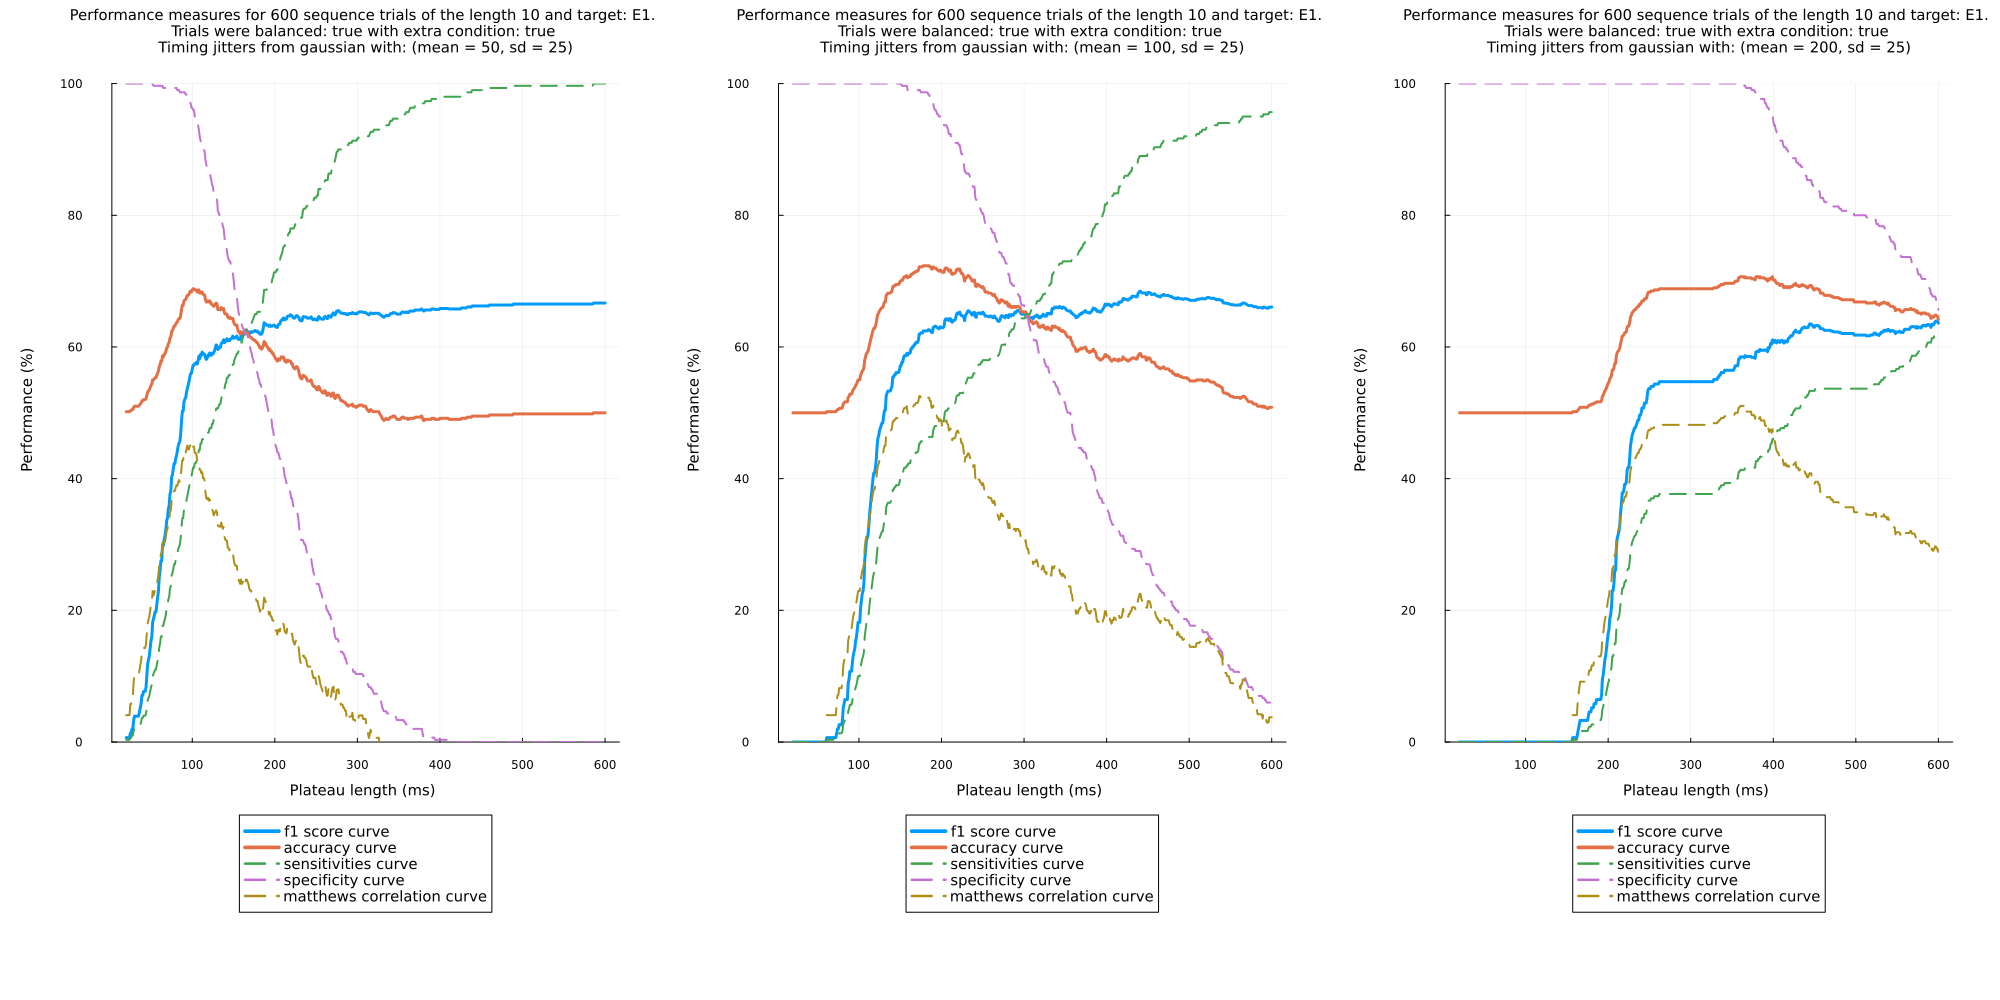

In [22]:
# CREATE PERFORMANCE OVERVIEW PNG 
plot1 = draw(performances[50],string(distname);setup=experiment_setup)
plot2 = draw(performances[100],string(distname);setup=experiment_setup)
plot3 = draw(performances[200],string(distname);setup=experiment_setup)
combined_plot = plot(plot1, plot2, plot3,  layout=(1,3), size=(2000, 1000), margin=10mm)
#savefig(combined_plot,"Performance "*experiment_filename* " mean in range 1 to 400 step of 1.png")

Plots.AnimatedGif("C:\\Users\\lisag\\AppData\\Local\\Temp\\jl_XS7QHof8Ba.gif")
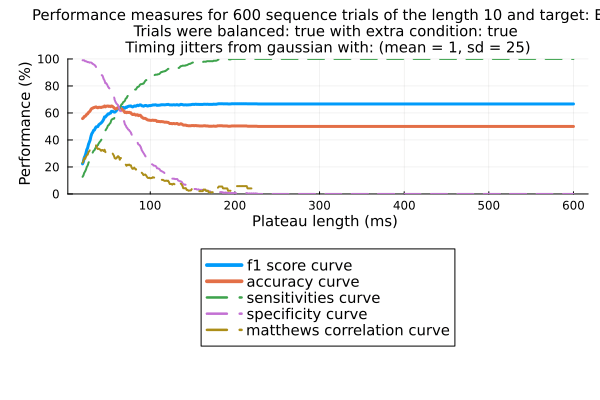

In [28]:
# CREATE GIF FOR PERFORMANCES 
anim = @animate for i in 1:length(performances)
    draw(performances[i],string(distname);setup=experiment_setup)
end
gif(anim, show_msg=false)
#gif(anim, "Performance " *experiment_filename* " mean in range 1 to 400 step of 1.gif", fps = 15)

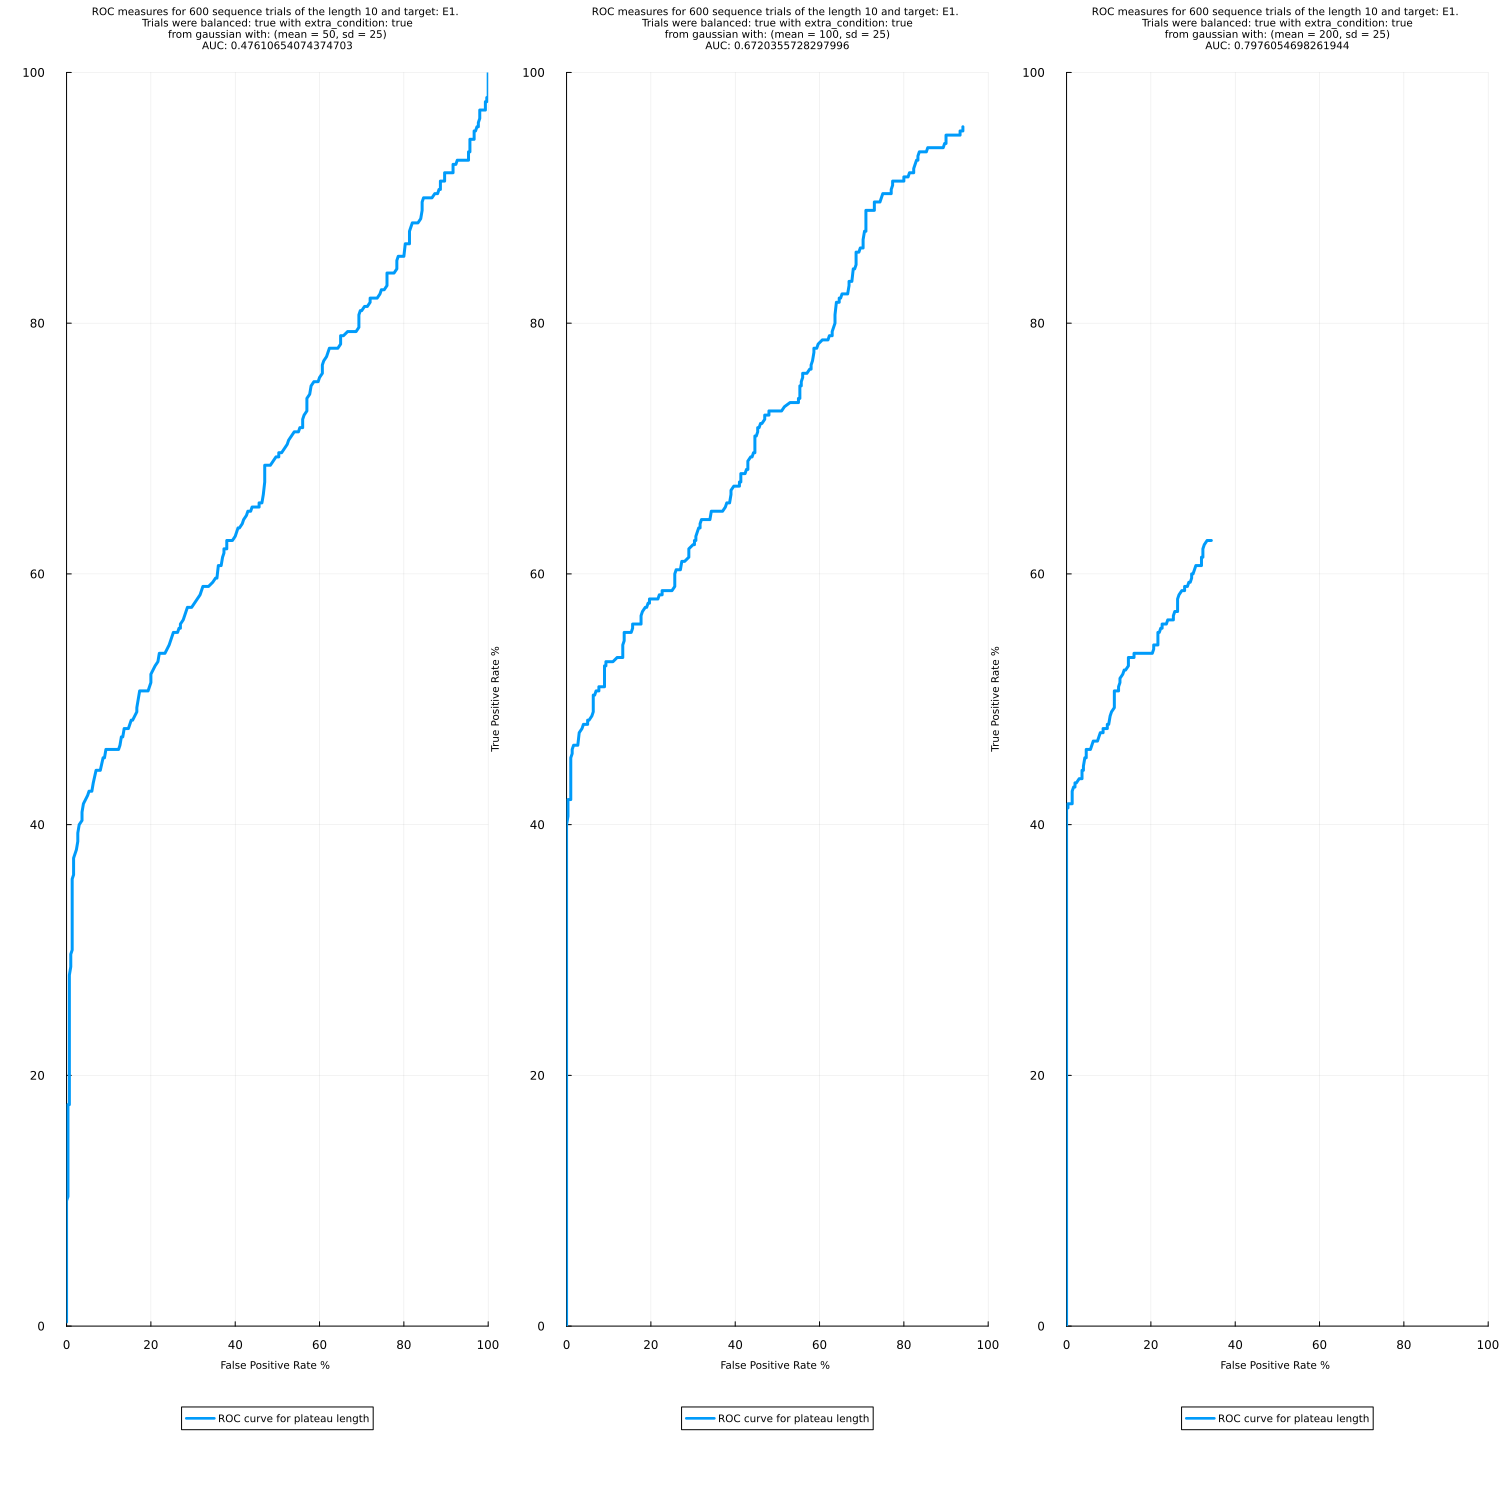

In [29]:
# CREATE ROC CURVE OVERVIEW PNG
plot1 = draw_roc(performances[50],string(distname);setup=experiment_setup)
plot2 = draw_roc(performances[100],string(distname);setup=experiment_setup)
plot3 = draw_roc(performances[200],string(distname);setup=experiment_setup)
combined_plot = plot(plot1, plot2, plot3, layout=(1, 3), size=(1500, 1500))
#savefig(combined_plot,"ROC curve "*experiment_filename*" mean in range 1 to 400 step of 1.png")

Plots.AnimatedGif("C:\\Users\\lisag\\AppData\\Local\\Temp\\jl_j6xevUbeR0.gif")
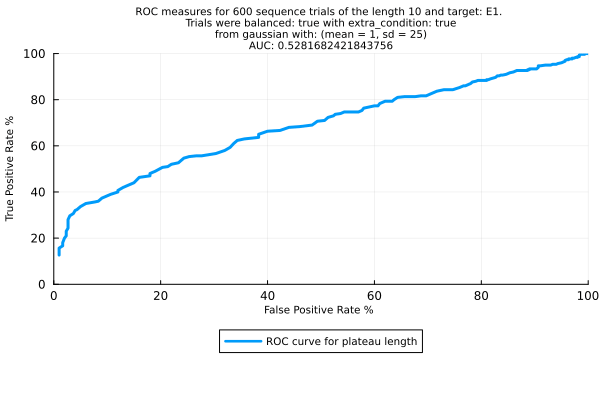

In [30]:
# CREATE GIF FOR ROC CURVES 
anim = @animate for i in 1:length(performances)
    draw_roc(performances[i],string(distname);setup=experiment_setup)
end
gif(anim, show_msg=false)
#gif(anim, "ROC " *experiment_filename*" mean in range 1 to 400 step of 1.gif", fps = 15)